# Baseline - IBRA

In [ ]:
import pandas as pd 
import numpy as np
from sklearn.utils import shuffle
import csv
import random
import sklearn
import pandas as pd
import plotly.express as px

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/Shareddrives/Projeto IBRA USP/Coleta de Dados/Datasets - IBRA/E1 - Hate Speech and Offensive Language/labeled_data.csv')

df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [ ]:
df.shape

(24783, 7)

In [ ]:
df['class_name'] = np.where(df['class'] == 0, 'Hate Speech', np.where(df['class'] == 1, 'Offensive Language', 'Neither'))
fig = px.histogram(df, x = df['class_name'])
fig.update_layout(
    autosize=False,
    width=900,
    height=300)
fig.show()

#### Binary Class to Hate speech

A class will be created that will have a value of 1 if it is offensive language or hate speech, and zero if it is not.


In [ ]:
def binaryClassHateSpeech(dataframe, mod=1):
  if(mod == 1): #Put together hate speech and Ofensive language
    dataframe['hate_ofensive_speech'] = dataframe['class'].apply(lambda x: 1 if x!=2 else 0)
  
  if(mod == 2): # It take just the hate speech
    dataframe['hate_ofensive_speech'] = dataframe['class'].apply(lambda x: 1 if x==0 else 0)
  
  return dataframe

In [ ]:
df = binaryClassHateSpeech(df, 1)
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet,class_name,hate_ofensive_speech
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,Neither,0
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,Offensive Language,1
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,Offensive Language,1
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,Offensive Language,1
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,Offensive Language,1


#### Separating Hashtags

In [ ]:
df['hashtags'] = df.tweet.str.findall(r'#.*?(?=\s|$)')
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet,class_name,hate_ofensive_speech,hashtags
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,Neither,0,[]
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,Offensive Language,1,[]
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,Offensive Language,1,[]
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,Offensive Language,1,[]
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,Offensive Language,1,[#57361;]


#### Making Samples to the model

In [1]:
# Separate dataset in train and test

def separate_train_and_test(df, class_column ,sub_classes_toTakeOff=[], sub_classes_toKeep=[], seed=42, percent_sample=0.1, sample_index=1):
  train_samples = []
  test_samples = [] # A test_sample it's gonna be all the dataset without a the elementes from train
  
  if sample_index*percent_sample > 1:
    print("ERRO: Invalide sample Index")
    return [], []

  df_without_subclasses = df

  # Cut of the subclasses we don't need
  for subclass in sub_classes_toTakeOff:
    df_without_subclasses = df[df[subclass] != 1]

  for subclass in sub_classes_toKeep:
    df_without_subclasses = df[df[subclass] == 1]

  df_without_subclasses = shuffle(df_without_subclasses, random_state=seed)
  tam_new_df = df_without_subclasses.shape[0]

  #Getting the samples, doing manual stratification
  df2 = df_without_subclasses[df_without_subclasses[class_column] == 1]
  tam_df2 = df2.shape[0]
  df_train2 = df2[int(percent_sample*tam_df2*(sample_index-1)):int(percent_sample*tam_df2*(sample_index))]
  df_test2  = df.loc[df[class_column] == 1].drop(df_train2.index)

  df3 = df_without_subclasses[df_without_subclasses[class_column] == 0]
  tam_df3 = df3.shape[0]
  df_train3 = df3[int(percent_sample*tam_df3*(sample_index-1)):int(percent_sample*tam_df3*(sample_index))]
  df_test3  = df.loc[df[class_column] == 0].drop(df_train3.index)

  #Juntar
  df_train = pd.concat([df_train3, df_train2])
  df_test = pd.concat([df_test3, df_test2])

  #aleatorizar
  df_train = shuffle(df_train, random_state=seed)
  df_test = shuffle(df_test, random_state=seed)

  return df_train, df_test

In [ ]:
# df_train, df_test = separate_train_and_test(df, class_column = 'hate_ofensive_speech',sub_classes_toTakeOff= ['subclass0'])
df_train, df_test = separate_train_and_test(df, class_column = 'hate_ofensive_speech')

In [ ]:
df_train.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet,class_name,hate_ofensive_speech,hashtags
12630,12944,3,0,2,1,1,Lololol joey lattimes phone just called him re...,Offensive Language,1,[]
936,956,3,0,0,3,2,&#127867;&#127867;&#127867;&#127804;&#128153;&...,Neither,0,[#127867;&#127867;&#127867;&#127804;&#128153;&...
550,559,3,0,3,0,1,"""She gotta shape up her pussy lips tho @PostPr...",Offensive Language,1,[]
15582,15947,3,1,2,0,1,RT @I_HATE_VA: Niggas be on here with these Ca...,Offensive Language,1,[#8230;]
8256,8485,3,0,1,2,2,But rich is a light skin coon. So it's expected.,Neither,0,[]


In [ ]:
df_test.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet,class_name,hate_ofensive_speech,hashtags
8185,8412,3,0,3,0,1,Bro I'm bored then a hoe rt,Offensive Language,1,[]
21011,21462,3,1,2,0,1,Sold weed to a bitch who's gonna be a lawyer.....,Offensive Language,1,[]
3439,3529,3,0,3,0,1,@IAMHICK3Y @chillbr0chill bitches on my dick b...,Offensive Language,1,[]
7827,8047,3,0,3,0,1,As soon as bitches get on a come up you got th...,Offensive Language,1,"[#128528;&#128528;., #Haters]"
15382,15745,3,0,3,0,1,RT @Gresham_Major: U tell us you fuckin barbar...,Offensive Language,1,[]


#### Data Cleaning and Word Counter

In [ ]:
import re
import string as str
import nltk
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from itertools import islice
import matplotlib.pyplot as plt
import seaborn as sb

nltk.download('punkt')
nltk.download('stopwords')
STOP_WORDS = stopwords.words()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Recebe uma coluna com os textos e retorna um DataFrame com as top n palavras mais frequentes e a quantidade de vezes que aparece
def word_counter (df, number):
  word_count = Counter(" ".join(df).split()).most_common(number)
  word_frequency = pd.DataFrame(word_count, columns = ['Word', 'Frequency'])
  
  return word_frequency

In [ ]:
# Tira caracteres especiais e stop-words
def cleaning(text):
    """
    Convert to lowercase.
    Rremove URL links, special characters and punctuation.
    Tokenize and remove stop words.
    """
    text = text.lower()
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(str.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('[’“”…]', '', text)

    # text = re.sub('rt', '', text)
    # text = re.sub('dont', '', text)

    # removing the stop-words
    text_tokens = word_tokenize(text)
    tokens_without_sw = [
        word for word in text_tokens if not word in STOP_WORDS]
    filtered_sentence = (" ").join(tokens_without_sw)
    text = filtered_sentence

    return text

### Most common words

In [ ]:
def baseline_fit(df_train, n, column_name) :
  df_train[column_name] = df_train[column_name].apply(cleaning)

  train_target = df_train.loc[df_train['hate_ofensive_speech'] == 1]
  train_not_target = df_train.loc[df_train['hate_ofensive_speech'] == 0]

  train_top_n_target = word_counter(train_target[column_name], len(train_target))
  train_top_n_not_target = word_counter(train_not_target[column_name], n)

  classifier_list = train_top_n_target.loc[~train_top_n_target.Word.isin(train_top_n_not_target['Word'].tolist())]
  classifier_list.reset_index(drop=True, inplace=True)

  return classifier_list.head(n)

In [ ]:
def baseline_classifier(df_test, classifier_list) :
  df_test['classifier'] = df_test['tweet'].str.contains(classifier_list)
  return df_test

#### Training Model

In [ ]:
classifier_list = baseline_fit(df_train, 10, 'tweet')
classifier_list

,Word,Frequency
0,bitch,843
1,bitches,296
2,hoes,222
3,pussy,212
4,ass,175
5,got,138
6,fuck,134
7,get,133
8,shit,121
9,nigga,113


#### Testing Model

In [ ]:
df_test['classifier'] = df_test['tweet'].str.contains('|'.join(classifier_list['Word']))

In [ ]:
def plot_confusion_matrix(y, y_pred, beta = 1):
    """
    It receives an array with the ground-truth (y)
    and another with the prediction (y_pred), both with binary labels
    (positve=+1 and negative=-1) and plots the confusion
    matrix.
    It uses P (positive class id) and N (negative class id)
    which are "global" variables ...
    """
    TP = np.sum((y_pred == 1) * (y == 1))
    TN = np.sum((y_pred == 0) * (y == 0))

    FP = np.sum((y_pred == 1) * (y == 0))
    FN = np.sum((y_pred == 0) * (y == 1))

    total = TP+FP+TN+FN

    accuracy = (TP+TN)/total
    recall = (TP)/(TP+FN)
    precision = (TP)/(TP+FP)

    Fbeta = (precision*recall)*(1+beta**2)/(beta**2*precision + recall)
    
    print("TP = %4d    FP = %4d\nFN = %4d    TN = %4d\n"%(TP,FP,FN,TN))
    print("Accuracy = %d / %d (%f)" %((TP+TN),total, (TP+TN)/total))
    print("Recall = %d / %d (%f)" %((TP),(TP+FN), (TP)/(TP+FN)))
    print("Precision = %d / %d (%f)" %((TP),(TP+FP), (TP)/(TP+FP)))
    print("Fbeta Score = %f" %(Fbeta))

    confusion = [
        [TP/(TP+FN), FP/(TN+FP)],
        [FN/(TP+FN), TN/(TN+FP)]
    ]

    P = 1
    N = 0

    df_cm = pd.DataFrame(confusion, \
                         ['$\hat{y} = %d$'%P, '$\hat{y} = %d$'%N],\
                         ['$y = %d$'%P, '$y = %d$'%N])
    
    plt.figure(figsize = (8,4))
    sb.set(font_scale=1.4)
    sb.heatmap(df_cm, annot=True) #, annot_kws={"size": 16}, cmap = 'coolwarm')
    plt.show()

/usr/local/lib/python3.7/dist-packages/pandas/core/computation/expressions.py:204: UserWarning:

evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead

/usr/local/lib/python3.7/dist-packages/pandas/core/computation/expressions.py:204: UserWarning:

evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead

/usr/local/lib/python3.7/dist-packages/pandas/core/computation/expressions.py:204: UserWarning:

evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead

/usr/local/lib/python3.7/dist-packages/pandas/core/computation/expressions.py:204: UserWarning:

evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead



TP = 15530    FP =  454
FN = 3028    TN = 3293

Accuracy = 18823 / 22305 (0.843892)
Recall = 15530 / 18558 (0.836836)
Precision = 15530 / 15984 (0.971597)
Fbeta Score = 0.860712


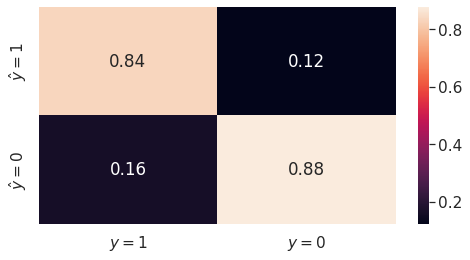

In [ ]:
plot_confusion_matrix(df_test['hate_ofensive_speech'], df_test['classifier'], beta =2)

### Hashtags Counter

In [ ]:
hashtag_list = baseline_fit(df_train, 10, 'hashtags')
hashtag_list

KeyError: ignored